In [43]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StringIndexer, PCA
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
import time

In [44]:
# Initialize Spark Session
spark = SparkSession.builder.appName('Predict_Stall_Events_with_PCA').getOrCreate()

In [45]:
# Load the dataset
hdfs_path = "hdfs://hadoop-namenode:9000/assignment/datasets/Dataset-QOE-cleaned.csv"
dataset = spark.read.format("csv").option("header", True).load(hdfs_path)

In [46]:
# Selecting relevant columns and casting them to appropriate types
selected_columns = [
    '95 Input Rate Variation', 'Avg Download Bit Rate', 'Rebuffering Ratio',
    'Avg Video Buffer Level', 'Std Video Download Rate', 'Avg Quality Index',
    'Total Stalling Time', 'Request Duration', 'Bottleneck Bandwidth', 
    'Stall Label', 'Bottleneck Packet Loss',
    'Stall Events'
]

# Filter the dataset with selected columns
dataset = spark_df.select([col(c).cast("float") if c not in ['Bottleneck Packet Loss', 'Stall Label'] else col(c) for c in selected_columns])

In [47]:
# String indexing for categorical columns

indexers = [
    StringIndexer(inputCol='Bottleneck Packet Loss', outputCol='BottleneckPacketLoss_Indexed'),
    StringIndexer(inputCol='Stall Label', outputCol='StallLabel_Indexed')
]

pipeline = Pipeline(stages=indexers)
dataset = pipeline.fit(dataset).transform(dataset)

# Dropping original categorical column after indexing
dataset = dataset.drop('Bottleneck Packet Loss')
dataset = dataset.drop("Stall Label")

In [48]:
# Assembling all features into a single feature vector
assembler = VectorAssembler(
    inputCols=[c for c in dataset.columns if c not in ['Stall Events', 'Stall Label']] + ['StallLabel_Indexed'],
    outputCol='features'
)
dataset = assembler.transform(dataset)

In [56]:
# Define PCA
pca = PCA(k=5, inputCol="features", outputCol="pcaFeatures")

In [57]:
# Define the Random Forest Regressor model
rf = RandomForestRegressor(featuresCol='pcaFeatures', labelCol='Stall Events')

In [58]:
# Create a pipeline
pipeline = Pipeline(stages=indexers + [assembler, pca, rf])

In [59]:
# Split the dataset into training and testing sets
train_data, test_data = spark_df.randomSplit([0.8, 0.2], seed=1234)

In [60]:
# Train the model with PCA
start_time = time.time()
pca_model = pipeline.fit(train_data)
pca_predictions = pca_model.transform(test_data)
end_time = time.time()

In [61]:
# Evaluate the model
evaluator = RegressionEvaluator(labelCol='Stall Events', predictionCol='prediction', metricName='rmse')
pca_rmse = evaluator.evaluate(pca_predictions)

In [62]:
# Results
pca_time_taken = end_time - start_time
pca_rmse, pca_time_taken

(0.5947556659008054, 1.891050100326538)

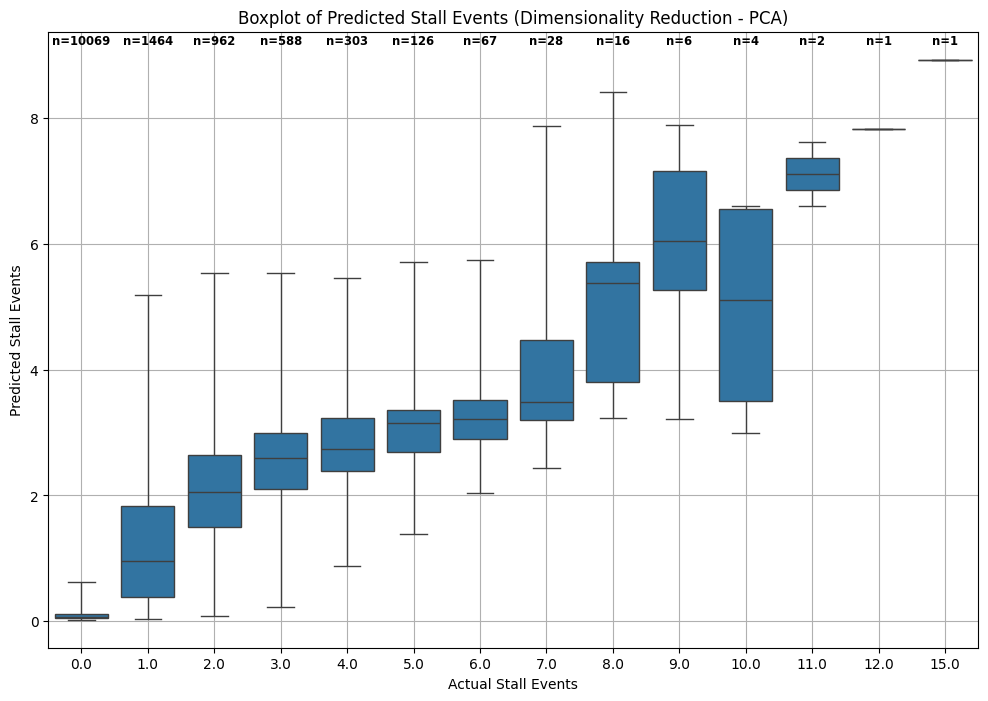

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

results = pca_predictions.select('prediction', 'Stall Events').collect()

predicted_values = [row['prediction'] for row in results]
actual_values = [row['Stall Events'] for row in results]

df = pd.DataFrame({
    'Predicted': predicted_values,
    'Actual': actual_values
})

# Create a boxplot
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x='Actual', y='Predicted', data=df, whis=[0, 100])

# Calculate number of observations per category (To annotate)
num_observations = df.groupby('Actual')['Predicted'].size().reset_index(name='counts')
y_offset = 0.2

for i in range(len(num_observations)):
    # Position text above the boxplot
    ax.text(i, ax.get_ylim()[1] - y_offset, f'n={num_observations["counts"][i]}', 
            horizontalalignment='center', size='small', color='black', weight='semibold')

plt.title('Boxplot of Predicted Stall Events (Dimensionality Reduction - PCA)')
plt.xlabel('Actual Stall Events')
plt.ylabel('Predicted Stall Events')
plt.grid(True)
plt.show()
